This notebook opens the ESO-MPG files and plots the hand-picked error analysis squares within them (both in home/maykerchen.1/Desktop/SNeHaLargeData/)


In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.io import fits
from astropy.wcs import WCS
import sys, os
#!{sys.executable} -m pip install aplpy
import numpy as np
import aplpy
from astropy.table import Table, join

In [2]:
#Load NB galaxy file data

NBtable = Table.read('../Data/0.NBdata.csv', format = "csv")
NBtable.sort("Galaxy")

NBtable[0]

Galaxy,ESO-MPG_Hasub_wcomb_corr
str8,str89
IC5332,/home/maykerchen.1/Desktop/SNeHaLargeData/HaSUB_wcomb_corr/IC5332_Hasub_flux_corrs.fits


In [3]:
# Store file information for plotting
galaxies, plots, wcss, hdus, xcoords, ycoords, heights, widths, valmins, valmaxs = [],[],[],[],[],[],[],[],[],[]

for i in range(len(NBtable)):
    fileName = NBtable["ESO-MPG_Hasub_wcomb_corr"][i]

    if os.path.isfile(fileName):
        NB_hdu = fits.open(fileName)
        NB_map = NB_hdu[0].data
        wcs = WCS(NB_hdu[0].header, naxis=2)
        
        regName = "/home/maykerchen.1/Desktop/SNeHaLargeData/" + NBtable["Galaxy"][i] + ".reg"
        if os.path.isfile(regName):
            galaxies.append(NBtable["Galaxy"][i])
            hdus.append(NB_hdu)
            plots.append(NB_map)
            wcss.append(wcs)
            
            xcoord, ycoord, height, width = np.genfromtxt(regName, dtype = int, delimiter = " ", unpack=True, usecols = (1,2,3,4))
            xcoords.append(xcoord)
            ycoords.append(ycoord)
            heights.append(height)
            widths.append(width)

            valmins.append(np.nanpercentile(NB_map,5))
            valmaxs.append(np.nanpercentile(NB_map,95))

        else: pass
                         
    else:
        print("File Not Found: ", fileName)
    


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<ipython-input-4-a850fe687061>:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("magma"))
  current_cmap.set_bad("black")
<ipython-input-4-a850fe687061>:12: RuntimeWarning: invalid value encountered in log10
  logplot = np.log10(plot)
<ipython-input-4-a850fe687061>:12: RuntimeWarning: divide by zero encountered in log10
  logplot = np.log10(plot)


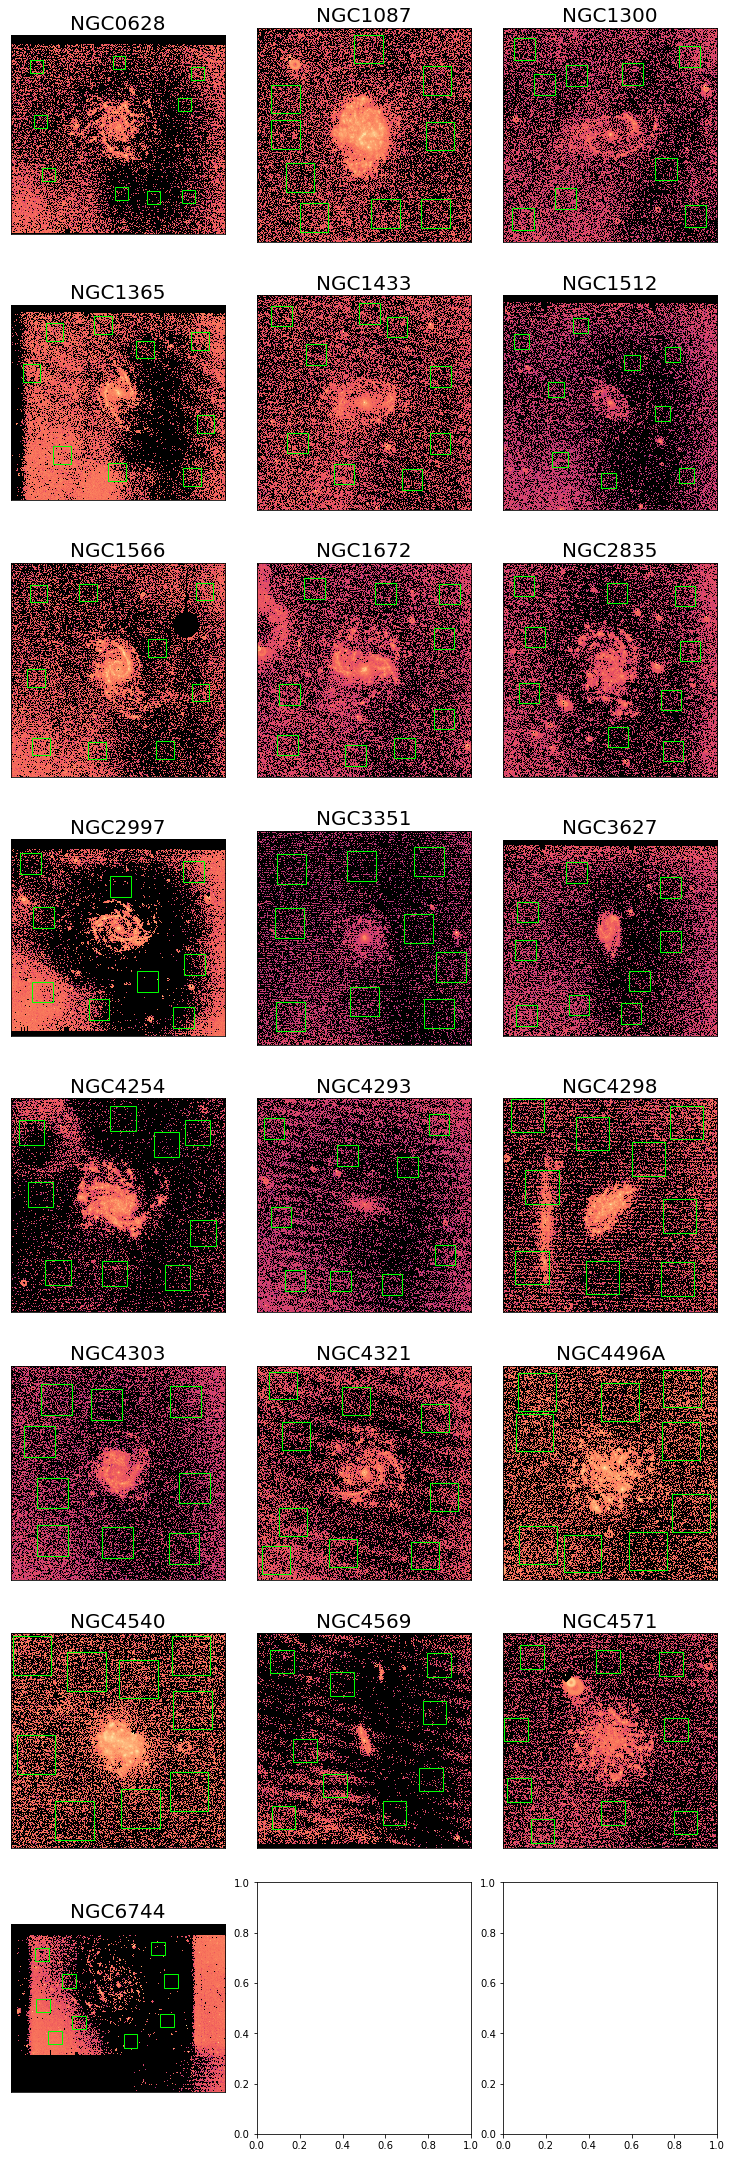

In [4]:
# make multipanel plot of NB galaxies with error boxes
# plots, wcss, hdus, xcoords, ycoords, heights, widths, valmins, valmaxs
        
current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

import math
i,j,m=0,0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(10, 30))
for plot in plots:
    logplot = np.log10(plot)
    axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest")
    #axs[i][j].imshow(plot, cmap=current_cmap, origin = "lower", interpolation = "nearest", vmin=valmins[m], vmax=valmaxs[m])
    axs[i][j].set_title(galaxies[m].upper(), fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    
    for x in range(len(xcoords[m])):
        xstart = xcoords[m][x]-(heights[m][x])/2
        ystart = ycoords[m][x]-(heights[m][x])/2
        axs[i][j].add_patch(Rectangle((xstart, ystart), heights[m][x], widths[m][x], alpha=1, edgecolor='lime', fill = False))
            
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m+=1
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
plt.show()
fig.savefig("../Figures/ESO-MPGGalaxiesErrorBoxes.png", dpi=100)
plt.close()
    
    

In [5]:
import astropy
#evaluate standard deviaton and median value for each box

StandardDevs, Medians = [],[]

for i in range(len(plots)):
#for i in range(0,1):
    std, med = [],[]
    
    for j in range(len(xcoords[i])):

        xstart = int(xcoords[i][j] -  (heights[i][j])/2)
        xend =  int(xcoords[i][j] + (heights[i][j])/2)
        ystart = int(ycoords[i][j] - (heights[i][j])/2)
        yend = int(ycoords[i][j] + (heights[i][j])/2)
    
        boxVals = plots[i][xstart:xend,ystart:yend]
        index = np.isfinite(boxVals)
    
        std.append(astropy.stats.mad_std(boxVals[index]))
        med.append(np.median(boxVals[index]))
#         print(index)
#         print(med)

    StandardDevs.append(std)
    Medians.append(med)

In [6]:
#Find 16th, 50th, 84th %ile from the median values of the 9 boxes
#percentiles = [0.5/9,1.5/9,2.5/9,3.5/9,4.5/9,5.5/9,6.5/9,7.5/9,8.5/9]

def findSigma(statnoiseArr,medianArr):
    # find sigma_rms by averaging the std values for each box
    statNoise = np.sort(statnoiseArr)
    sigma_std = np.average(statNoise)
    # find sigma_back by finding the 1 sigma deviation in the median values of the boxes
    sortArr = np.sort(medianArr)
    sixteen = sortArr[1]
    fifty = sortArr[4]
    eightythree = sortArr[7]
    tiles = [sixteen, fifty, eightythree]
    sigma_back =  (eightythree-sixteen)/2.0
    # find the overall noise by adding the errors in quadrature
    Sigma = np.sqrt(sigma_std**2 + sigma_back**2)
    return(Sigma, statNoise, sigma_std, tiles, sigma_back)


fileName = "../Data/0.ESO-MPG_Map_Noise.txt"

with open(fileName,"w") as text_file:
    print("#Galaxy, Noise, stdev, background", file=text_file)
    
    for i in range(len(plots)):
        Sigma, statNoise, sigma_std, tiles, sigma_back = findSigma(StandardDevs[i],Medians[i])
        print(galaxies[i],",",Sigma,",", sigma_std,",", sigma_back, file=text_file)
text_file.close()
    
    